In [34]:
import csv
from datetime import datetime, timedelta


# Function to parse date string to datetime object
def parse_datetime(date_str):
    return datetime.strptime(date_str, "%m/%d/%y %I:%M:%S %p")


# Read the csv file
data = []
with open('data.csv', 'r') as file:
    reader = csv.reader(file)
    # Skip the header
    next(reader)
    for row in reader:
        data.append(row)


# Process the data and add missing times
new_data = []
previous_light = None
previous_occupancy = None
for i, row in enumerate(data):
    date_time, light, occupancy = row[1], row[2], row[3]
    date_time_obj = parse_datetime(date_time)

    if previous_light is None:
        previous_light = light

    if previous_occupancy is None:
        previous_occupancy = occupancy

    # Adding the missing times
    if i > 0:
        prev_date_time_obj = parse_datetime(data[i-1][1])
        while date_time_obj - prev_date_time_obj > timedelta(seconds=1):
            prev_date_time_obj = prev_date_time_obj + timedelta(seconds=1)
            new_data.append([
                prev_date_time_obj.strftime("%m/%d/%y %I:%M:%S %p"),
                previous_light,
                previous_occupancy
            ])

    # Adding the current row
    new_data.append([date_time, light or previous_light, occupancy or previous_occupancy])
    previous_light = light or previous_light
    previous_occupancy = occupancy or previous_occupancy


# Write the new data to a new csv file
with open('new_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Writing header
    writer.writerow(['Date Time, GMT-04:00', 'Light', 'Occupancy'])
    # Writing the data
    for row in new_data:
        writer.writerow(row)


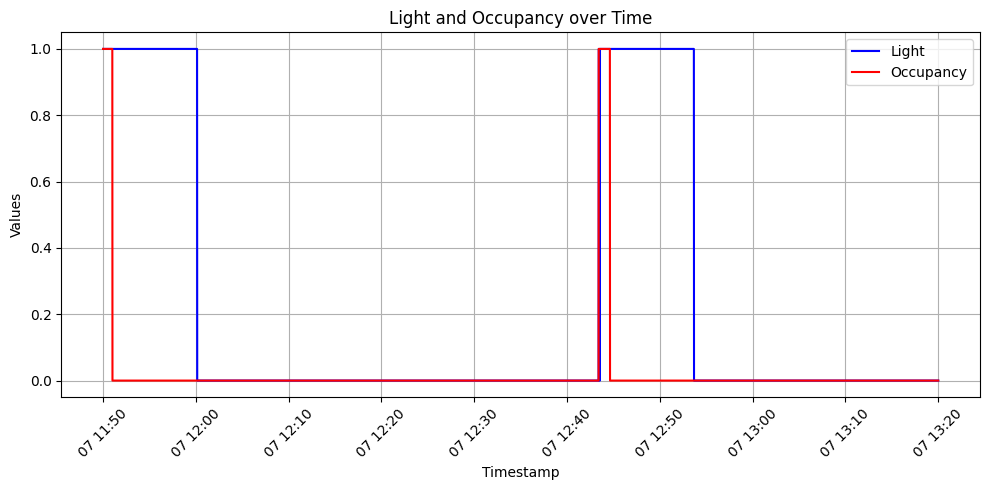

Total time when lights are on but no occupancy: 0:18:11
Total cost: $0.91


In [35]:
import csv
import matplotlib.pyplot as plt
from datetime import datetime




# Function to parse date string to datetime object
def parse_datetime(date_str):
    return datetime.strptime(date_str, "%m/%d/%y %I:%M:%S %p")

# Specify the time range
start_time = parse_datetime("07/07/23 11:50:00 AM")
end_time = parse_datetime("07/07/23 01:20:00 PM")

# Read the new_data.csv file
timestamps = []
light_values = []
occupancy_values = []
with open('new_data.csv', 'r') as file:
    reader = csv.reader(file)
    # Skip the header
    next(reader)
    for row in reader:
        current_time = parse_datetime(row[0])
        # Check if the current time is within the selected range
        if start_time <= current_time <= end_time:
            timestamps.append(current_time)
            light_values.append(float(row[1]))
            occupancy_values.append(float(row[2]))

# Calculating time when lights are on but no occupancy
lights_on_no_occupancy = timedelta(0)
inside_interval = False
start_interval = None

for i in range(len(timestamps)):
    if light_values[i] == 1.0 and occupancy_values[i] == 0.0:
        if not inside_interval:
            start_interval = timestamps[i]
            inside_interval = True
    else:
        if inside_interval:
            end_interval = timestamps[i]
            lights_on_no_occupancy += end_interval - start_interval
            inside_interval = False

# Adding the last interval if it ends at the last data point
if inside_interval:
    lights_on_no_occupancy += timestamps[-1] - start_interval

# Plotting the data
plt.figure(figsize=(10, 5))

# Plot light values
plt.plot(timestamps, light_values, label='Light', color='blue')

# Plot occupancy values
plt.plot(timestamps, occupancy_values, label='Occupancy', color='red')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Light and Occupancy over Time')
plt.legend()
plt.grid(True)

# Rotate date labels
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

kw_usage = float(input("Enter kW usage of lights"))
usd_kw = float(input("Enter cost per kW in USD"))
hours_lights_on_no_occupancy = lights_on_no_occupancy.total_seconds() / 3600

total_cost = kw_usage * hours_lights_on_no_occupancy * usd_kw

# Printing the total time when lights are on but no occupancy
print(f"Total time when lights are on but no occupancy: {lights_on_no_occupancy}")
print(f'Total cost: ${round(total_cost, 2)}')

In [40]:
import os
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json

# Function to parse date string to datetime object
def parse_datetime(date_str):
    return datetime.strptime(date_str, "%m/%d/%y %I:%M:%S %p")

# Make sure output directories exist
if not os.path.exists('newsensordata'):
    os.makedirs('newsensordata')

if not os.path.exists('output'):
    os.makedirs('output')

total_total_time = 0
output_dict = {}


# Loop through all csv files in the sensordata directory
for filename in os.listdir('sensordata'):
    if filename.endswith('.csv'):
        # Read the csv file
        data = []
        with open(os.path.join('sensordata', filename), 'r') as file:
            reader = csv.reader(file)
            # Skip the header
            next(reader)
            for row in reader:
                data.append(row)
        
        # Process the data and add missing times
        new_data = []
        previous_light = None
        previous_occupancy = None
        for i, row in enumerate(data):
            date_time, light, occupancy = row[1], row[2], row[3]
            date_time_obj = parse_datetime(date_time)
            if previous_light is None:
                previous_light = light
            if previous_occupancy is None:
                previous_occupancy = occupancy
            # Adding the missing times
            if i > 0:
                prev_date_time_obj = parse_datetime(data[i-1][1])
                while date_time_obj - prev_date_time_obj > timedelta(seconds=1):
                    prev_date_time_obj = prev_date_time_obj + timedelta(seconds=1)
                    new_data.append([
                        prev_date_time_obj.strftime("%m/%d/%y %I:%M:%S %p"),
                        previous_light,
                        previous_occupancy
                    ])
            # Adding the current row
            new_data.append([date_time, light or previous_light, occupancy or previous_occupancy])
            previous_light = light or previous_light
            previous_occupancy = occupancy or previous_occupancy

        # Write the new data to a new csv file
        with open(os.path.join('newsensordata', 'new_' + filename), 'w', newline='') as file:
            writer = csv.writer(file)
            # Writing header
            writer.writerow(['Date Time, GMT-04:00', 'Light', 'Occupancy'])
            # Writing the data
            for row in new_data:
                writer.writerow(row)
        
        # Read the new_data.csv file
        timestamps = []
        light_values = []
        occupancy_values = []
        with open(os.path.join('newsensordata', 'new_' + filename), 'r') as file:
            reader = csv.reader(file)
            # Skip the header
            next(reader)
            for row in reader:
                current_time = parse_datetime(row[0])
                timestamps.append(current_time)
                light_values.append(float(row[1]))
                occupancy_values.append(float(row[2]))
        
        # Plotting the data
        plt.figure(figsize=(10, 5))

        # Plot light values
        plt.plot(timestamps, light_values, label='Light', color='blue')

        # Plot occupancy values
        plt.plot(timestamps, occupancy_values, label='Occupancy', color='red')

        # Adding labels and title
        plt.xlabel('Timestamp')
        plt.ylabel('Values')
        plt.title('Light and Occupancy over Time')
        plt.legend()
        plt.grid(True)

        # Rotate date labels
        plt.xticks(rotation=45)

        # Save plot
        plt.tight_layout()
        plt.savefig(os.path.join('output', filename.split('.')[0] + '.png'))
        plt.close()
        
        # Calculate and print the total time when lights are on but no occupancy
        total_time = timedelta(0)
        for i in range(1, len(light_values)):
            if light_values[i] == 1.0 and occupancy_values[i] == 0.0:
                total_time += timestamps[i] - timestamps[i-1]



        # Store the filename, total_time, and the png filepath
        output_dict[filename] = {
            'total_time': str(total_time),
            'png_filepath': os.path.join('output', filename.split('.')[0] + '.png')
        }


with open('output.json', 'w') as json_file:
    json.dump(output_dict, json_file, indent=4)
